# 03 — Audio emotion (speech)

Load per-clip metadata, run exploratory analysis, extract speech-based emotion probabilities with HuBERT, and export artifacts for fusion.


In [14]:
from pathlib import Path
import pandas as pd

def build_manifest_from_kaggle(kaggle_dataset_path: Path, audio_manifest: Path, sample_manifest: Path):
    train_csv = kaggle_dataset_path / "TRAIN.csv"
    train_dir = kaggle_dataset_path / "TRAIN"
    if not train_csv.exists() or not train_dir.exists():
        print("Kaggle dataset missing TRAIN.csv or TRAIN directory; cannot auto-build manifest.")
        return None

    train_df = pd.read_csv(train_csv)
    manifest_rows = []
    for _, row in train_df.iterrows():
        filename = str(row.get("Filename", "")).strip()
        label = str(row.get("Class", "")).strip()
        if not filename:
            continue
        clip_path = train_dir / filename
        if not clip_path.exists():
            print(f"Warning: missing audio file for {filename}; skipping")
            continue
        manifest_rows.append(
            {
                "sample_id": Path(filename).stem,
                "audio_path": str(clip_path),
                "label": label or "Unknown",
                "t_start": 0.0,
                "t_end": None,
            }
        )

    if not manifest_rows:
        print("No labelled rows discovered in Kaggle dataset to build manifest.")
        return None

    manifest_df = (
        pd.DataFrame(manifest_rows)
        .drop_duplicates(subset=["sample_id"], keep="first")
        .sort_values("sample_id")
        .reset_index(drop=True)
    )

    expected_rows = len(train_df)
    actual_rows = len(manifest_df)
    if actual_rows != expected_rows:
        print(
            f"Warning: manifest row count ({actual_rows}) differs from TRAIN.csv ({expected_rows})."
            " Check for missing files or duplicates."
        )
    else:
        print("Manifest row count matches TRAIN.csv")

    manifest_df.to_csv(audio_manifest, index=False)
    print(f"Wrote audio manifest with {len(manifest_df)} labelled entries at {audio_manifest}")
    if len(manifest_df) > 10:
        manifest_df.head(10).to_csv(sample_manifest, index=False)
        print(f"Sample manifest (first 10 rows) also saved at {sample_manifest}")
    return manifest_df

audio_manifest = Path("../data/raw/audio/audio_manifest.csv")
manifest_root = audio_manifest.parent
sample_manifest = audio_manifest.with_name("audio_manifest_SAMPLE_FROM_KAGGLE.csv")
template_manifest = audio_manifest.with_name("audio_manifest_TEMPLATE.csv")
manifest_root.mkdir(parents=True, exist_ok=True)

if not template_manifest.exists():
    template = pd.DataFrame(
        {
            "sample_id": ["sample_audio_000"],
            "audio_path": ["clips/sample_clip.wav"],
            "label": ["Neutral"],
            "t_start": [0.0],
            "t_end": [5.0],
        }
    )
    template.to_csv(template_manifest, index=False)
    print(f"Created audio manifest template at {template_manifest}")

kaggle_dataset_path = None
try:
    import kagglehub
    try:
        kaggle_dataset_path = Path(kagglehub.dataset_download("imsparsh/audio-speech-sentiment"))
        print(f"Downloaded imsparsh/audio-speech-sentiment to {kaggle_dataset_path}")
    except Exception as exc:
        print(f"Warning: could not download Kaggle audio dataset ({exc}).")
        kaggle_dataset_path = None
except ModuleNotFoundError:
    kaggle_dataset_path = None
    print("kagglehub is not installed; skip automatic audio download.")

if not audio_manifest.exists() and kaggle_dataset_path is not None:
    manifest_df = build_manifest_from_kaggle(kaggle_dataset_path, audio_manifest, sample_manifest)
else:
    manifest_df = None

if not audio_manifest.exists():
    if sample_manifest.exists():
        audio_manifest = sample_manifest
        print(f"Using sample manifest: {audio_manifest}")
    else:
        raise FileNotFoundError(
            "Audio manifest missing. Provide '../data/raw/audio/audio_manifest.csv' (or rerun the Kaggle download)."
        )

audio_df = pd.read_csv(audio_manifest)
if "label" not in audio_df.columns and kaggle_dataset_path is not None:
    print("Existing manifest missing label column; rebuilding from Kaggle metadata.")
    manifest_df = build_manifest_from_kaggle(kaggle_dataset_path, audio_manifest, sample_manifest)
    if manifest_df is None:
        raise ValueError("Unable to rebuild manifest with audio labels; aborting.")
    audio_df = manifest_df

if manifest_df is not None and len(manifest_df) != len(audio_df):
    print("Warning: Loaded manifest row count differs from freshly built manifest; using rebuilt version.")
    audio_df = manifest_df

required_cols = {"sample_id", "audio_path", "label"}
missing_cols = required_cols - set(audio_df.columns)
if missing_cols:
    raise ValueError(f"Audio manifest missing required columns: {sorted(missing_cols)}")

audio_df["audio_path"] = audio_df["audio_path"].apply(
    lambda p: str((Path(audio_manifest).parent / p).resolve()) if not Path(p).is_absolute() else p
)

audio_df["sample_id"] = audio_df["sample_id"].astype(str)
audio_df["label"] = audio_df["label"].astype(str)
audio_df["t_start"] = pd.to_numeric(audio_df.get("t_start"), errors="coerce").fillna(0.0)
audio_df["t_end"] = pd.to_numeric(audio_df.get("t_end"), errors="coerce")
print(f"Prepared audio dataframe with {len(audio_df)} labelled entries")
print(audio_df.head(3))


Downloaded imsparsh/audio-speech-sentiment to /Users/mixberries13/.cache/kagglehub/datasets/imsparsh/audio-speech-sentiment/versions/2
Prepared audio dataframe with 250 labelled entries
  sample_id                                         audio_path     label  \
0       346  /Users/mixberries13/.cache/kagglehub/datasets/...  Negative   
1       163  /Users/mixberries13/.cache/kagglehub/datasets/...   Neutral   
2       288  /Users/mixberries13/.cache/kagglehub/datasets/...  Negative   

   t_start  t_end  
0      0.0    NaN  
1      0.0    NaN  
2      0.0    NaN  


Label distribution:
label
Negative    87
Positive    82
Neutral     81
Name: count, dtype: int64
No valid clip durations found; skipping duration histogram.


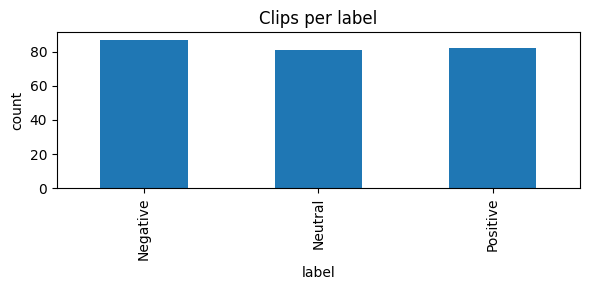

In [15]:
import sys
import subprocess

try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'matplotlib'])
    import matplotlib.pyplot as plt

label_series = audio_df.get('label')
if label_series is None or label_series.dropna().empty:
    print('Audio manifest has no labels available yet; skipping label plots.')
else:
    label_counts = label_series.value_counts()
    print('Label distribution:')
    print(label_counts)

    if {'t_start', 't_end'}.issubset(audio_df.columns):
        durations = (audio_df['t_end'] - audio_df['t_start']).clip(lower=0)
        if durations.notna().any():
            print(
                f"Clip duration stats (seconds): min={durations.min():.2f}, "
                f"median={durations.median():.2f}, max={durations.max():.2f}"
            )
            plt.figure(figsize=(6, 3))
            durations.dropna().hist(bins=20)
            plt.title('Audio clip durations')
            plt.xlabel('seconds')
            plt.ylabel('count')
            plt.tight_layout()
            plt.show()
        else:
            print('No valid clip durations found; skipping duration histogram.')
    else:
        print("Manifest missing 't_start' and/or 't_end' columns; skipping duration stats.")

    if not label_counts.empty:
        plt.figure(figsize=(6, 3))
        label_counts.sort_index().plot(kind='bar')
        plt.title('Clips per label')
        plt.xlabel('label')
        plt.ylabel('count')
        plt.tight_layout()
        plt.show()
    else:
        print('No label frequency data to plot.')


In [16]:
import os
os.environ["USE_TF"] = "1"
import subprocess
import sys

for package, module in [
    ("librosa", "librosa"),
    ("soundfile", "soundfile"),
    ("tqdm", "tqdm"),
    ("tensorflow", "tensorflow"),
    ("scikit-learn", "sklearn"),
    ("joblib", "joblib"),
]:
    try:
        __import__(module)
    except ModuleNotFoundError:
        print(f"Installing missing dependency: {package}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

import json
import librosa
import numpy as np
import tensorflow as tf
from tqdm.auto import tqdm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import joblib

# Original HuBERT dependency setup (kept for reference):
# for package, module in [
#     ('librosa', 'librosa'),
#     ('soundfile', 'soundfile'),
#     ('tqdm', 'tqdm'),
#     ('transformers', 'transformers'),
#     ('torchaudio', 'torchaudio'),
# ]:
#     try:
#         __import__(module)
#     except ModuleNotFoundError:
#         subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
# from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
# import torch


In [17]:
SR = 16_000
TARGET_DURATION = 4.0  # seconds
N_FFT = 1024
HOP_LENGTH = 256
N_MELS = 64


def load_waveform(path: str, target_len: int) -> np.ndarray:
    waveform, _ = librosa.load(path, sr=SR, mono=True)
    if len(waveform) < target_len:
        waveform = np.pad(waveform, (0, target_len - len(waveform)))
    else:
        waveform = waveform[:target_len]
    return waveform


def log_mel_spectrogram(waveform: np.ndarray) -> np.ndarray:
    spec = librosa.feature.melspectrogram(
        y=waveform,
        sr=SR,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS,
        power=2.0,
    )
    log_spec = librosa.power_to_db(spec, ref=np.max)
    return log_spec.astype(np.float32)


def infer_group_id(sample_id: str, group_size: int = 25) -> str:
    digits = ''.join(ch for ch in sample_id if ch.isdigit())
    if digits:
        return f"group_{int(digits) // max(group_size, 1)}"
    return f"group_{sample_id}"


target_length = int(SR * TARGET_DURATION)
spec_rows = []
meta_rows = []

for row in tqdm(list(audio_df.itertuples(index=False)), desc="Building spectrograms"):
    clip_path = Path(row.audio_path)
    if not clip_path.exists():
        print(f"Skipping missing audio file: {clip_path}")
        continue
    waveform = load_waveform(str(clip_path), target_length)
    log_spec = log_mel_spectrogram(waveform)
    spec_rows.append(log_spec[..., np.newaxis])
    row_dict = row._asdict()
    row_dict["group_id"] = infer_group_id(str(row_dict.get("sample_id", "")))
    meta_rows.append(row_dict)

if not spec_rows:
    raise RuntimeError("No audio spectrograms were generated. Check manifest paths.")

spec_array = np.stack(spec_rows)
meta_df = pd.DataFrame(meta_rows)
print(f"Spectrogram tensor shape: {spec_array.shape}")
print(meta_df[["sample_id", "label", "group_id"]].head())

# Original HuBERT model load (commented out):
# MODEL_ID = 'superb/hubert-large-superb-er'
# feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_ID)
# audio_model = AutoModelForAudioClassification.from_pretrained(MODEL_ID)
# id2label = audio_model.config.id2label


Building spectrograms:   0%|          | 0/250 [00:00<?, ?it/s]

Spectrogram tensor shape: (250, 64, 251, 1)
  sample_id     label  group_id
0       346  Negative  group_13
1       163   Neutral   group_6
2       288  Negative  group_11
3       279  Negative  group_11
4       244  Negative   group_9


In [18]:
import os
os.environ["USE_TF"] = "1"

AUGMENT_ENABLED = True
rng = np.random.default_rng(42)

REPEATS = 3
FOLDS = 3
NEGATIVE_AUG_MULTIPLIER = 1
POSITIVE_AUG_MULTIPLIER = 1
LABEL_SMOOTHING = 0.02
MAX_EPOCHS = 18

def random_time_shift(spec: np.ndarray, max_shift_frames: int = 6) -> np.ndarray:
    if max_shift_frames <= 0:
        return spec
    shift = int(rng.integers(-max_shift_frames, max_shift_frames + 1))
    if shift == 0:
        return spec
    shifted = np.zeros_like(spec)
    if shift > 0:
        shifted[:, shift:, :] = spec[:, :-shift, :]
    else:
        shift_mag = abs(shift)
        shifted[:, :-shift_mag, :] = spec[:, shift_mag:, :]
    return shifted

def spec_augment(spec: np.ndarray, max_freq_mask: int = 6, max_time_mask: int = 12) -> np.ndarray:
    augmented = spec.copy()
    mel_bins, time_steps, _ = augmented.shape
    freq_width = int(rng.integers(0, max_freq_mask + 1))
    if 0 < freq_width < mel_bins:
        freq_start = int(rng.integers(0, mel_bins - freq_width))
        augmented[freq_start:freq_start + freq_width, :, :] = 0.0
    time_width = int(rng.integers(0, max_time_mask + 1))
    if 0 < time_width < time_steps:
        time_start = int(rng.integers(0, time_steps - time_width))
        augmented[:, time_start:time_start + time_width, :] = 0.0
    return augmented

def augment_training_data(
    X: np.ndarray,
    y: np.ndarray,
    labels: np.ndarray,
    num_aug_per_sample: int = 1,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    if not AUGMENT_ENABLED or num_aug_per_sample <= 0:
        return X, y, labels

    augmented_specs = []
    augmented_targets = []
    augmented_labels = []
    for idx in range(len(X)):
        base_spec = X[idx]
        base_label = labels[idx]
        repeats = (
            NEGATIVE_AUG_MULTIPLIER
            if base_label == negative_class_idx
            else POSITIVE_AUG_MULTIPLIER
            if base_label == positive_class_idx
            else 1
        )
        repeats = max(repeats, num_aug_per_sample)
        for _ in range(repeats):
            augmented = spec_augment(random_time_shift(base_spec))
            augmented_specs.append(augmented.astype(np.float32))
            augmented_targets.append(y[idx])
            augmented_labels.append(labels[idx])

    if not augmented_specs:
        return X, y, labels

    X_aug = np.concatenate([X, np.stack(augmented_specs)], axis=0)
    y_aug = np.concatenate([y, np.stack(augmented_targets)], axis=0)
    labels_aug = np.concatenate([labels, np.array(augmented_labels)])
    return X_aug, y_aug, labels_aug

def oversample_training_data(
    X: np.ndarray,
    y: np.ndarray,
    labels: np.ndarray,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    counts = np.bincount(labels, minlength=num_classes)
    if counts.min() == counts.max():
        return X, y, labels
    max_count = counts.max()
    indices = np.arange(len(labels))
    extra_indices = []
    for class_idx, count in enumerate(counts):
        if count == 0:
            continue
        deficit = max_count - count
        if deficit <= 0:
            continue
        class_indices = indices[labels == class_idx]
        extra_indices.append(rng.choice(class_indices, size=deficit, replace=True))
    if not extra_indices:
        return X, y, labels
    extra_indices = np.concatenate(extra_indices)
    X_bal = np.concatenate([X, X[extra_indices]], axis=0)
    y_bal = np.concatenate([y, y[extra_indices]], axis=0)
    labels_bal = np.concatenate([labels, labels[extra_indices]])
    return X_bal, y_bal, labels_bal

labels = meta_df["label"].astype(str)
label_encoder = LabelEncoder()
label_ids = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
y_onehot = tf.keras.utils.to_categorical(label_ids, num_classes=num_classes)

class_counts = dict(zip(label_encoder.classes_, np.bincount(label_ids)))
print("Overall class counts:", class_counts)

negative_class_idx = int(label_encoder.transform(["Negative"])[0]) if "Negative" in label_encoder.classes_ else -1
positive_class_idx = int(label_encoder.transform(["Positive"])[0]) if "Positive" in label_encoder.classes_ else -1

rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=42)

fold_metrics = []
aggregate_cm = np.zeros((num_classes, num_classes), dtype=int)
best_model = None
best_history = None
best_spec_mean = None
best_spec_std = None
best_val_acc = -np.inf
best_val_loss = None
best_clean_acc = None
best_confusion = None

for split_idx, (train_idx, val_idx) in enumerate(rskf.split(spec_array, label_ids), start=1):
    X_train_clean = spec_array[train_idx]
    X_val = spec_array[val_idx]
    y_train_clean = y_onehot[train_idx]
    y_val = y_onehot[val_idx]
    train_labels_clean = label_ids[train_idx]
    val_labels = label_ids[val_idx]

    if np.unique(val_labels).size < num_classes or np.unique(train_labels_clean).size < num_classes:
        print("Skipping split with missing classes in train or validation")
        continue

    val_counts = np.bincount(val_labels, minlength=num_classes)
    print(f"Split {split_idx}: validation samples={len(X_val)}")
    print("Validation class counts:", dict(zip(label_encoder.classes_, val_counts.astype(int))))

    X_train_bal, y_train_bal, train_labels_bal = oversample_training_data(
        X_train_clean, y_train_clean, train_labels_clean
    )
    X_train_aug, y_train_aug, train_labels_aug = augment_training_data(
        X_train_bal, y_train_bal, train_labels_bal, num_aug_per_sample=1
    )

    spec_mean = float(X_train_aug.mean())
    spec_std = float(X_train_aug.std() + 1e-6)
    X_train_norm = (X_train_aug - spec_mean) / spec_std
    X_val_norm = (X_val - spec_mean) / spec_std
    spec_array_norm = (spec_array - spec_mean) / spec_std

    train_counts_clean = dict(zip(label_encoder.classes_, np.bincount(train_labels_clean, minlength=num_classes)))
    train_counts_used = dict(zip(label_encoder.classes_, np.bincount(train_labels_aug, minlength=num_classes)))
    print("Training class counts (clean):", train_counts_clean)
    print("Training class counts (used):", train_counts_used)

    class_weights_arr = compute_class_weight(
        class_weight="balanced",
        classes=np.arange(num_classes),
        y=train_labels_aug,
    )
    class_weights = {int(cls): float(weight) for cls, weight in enumerate(class_weights_arr)}

    tf.random.set_seed(42 + split_idx)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=X_train_norm.shape[1:]),
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),
        metrics=["accuracy"],
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy", patience=4, restore_best_weights=True, min_delta=5e-4
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1
        ),
    ]

    history = model.fit(
        X_train_norm,
        y_train_aug,
        validation_data=(X_val_norm, y_val),
        epochs=MAX_EPOCHS,
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=2,
    )

    val_loss, val_acc = model.evaluate(X_val_norm, y_val, verbose=0)
    clean_train_norm = (X_train_clean - spec_mean) / spec_std
    clean_eval_loss, clean_eval_acc = model.evaluate(clean_train_norm, y_train_clean, verbose=0)

    val_preds = np.argmax(model.predict(X_val_norm, batch_size=64), axis=1)
    cm = confusion_matrix(val_labels, val_preds, labels=np.arange(num_classes))
    aggregate_cm += cm

    fold_metrics.append({
        "split": int(split_idx),
        "val_accuracy": float(val_acc),
        "val_loss": float(val_loss),
        "clean_train_accuracy": float(clean_eval_acc),
        "confusion_matrix": cm.astype(int).tolist(),
        "history": {
            "accuracy": history.history.get("accuracy", []),
            "val_accuracy": history.history.get("val_accuracy", []),
        },
    })

    if val_acc > best_val_acc:
        best_val_acc = float(val_acc)
        best_val_loss = float(val_loss)
        best_clean_acc = float(clean_eval_acc)
        best_model = model
        best_history = history
        best_spec_mean = spec_mean
        best_spec_std = spec_std
        best_confusion = cm.copy()

if not fold_metrics:
    raise RuntimeError("Cross-validation produced no valid splits.")
if best_model is None:
    raise RuntimeError("No best model captured during CV.")

val_accs = np.array([m["val_accuracy"] for m in fold_metrics], dtype=float)
val_losses = np.array([m["val_loss"] for m in fold_metrics], dtype=float)
clean_accs = np.array([m["clean_train_accuracy"] for m in fold_metrics], dtype=float)

avg_val = float(val_accs.mean())
std_val = float(val_accs.std())
avg_val_loss = float(val_losses.mean())
avg_clean = float(clean_accs.mean())

print("\nCross-validation summary (stratified repeats):")
aggregate_confusion = aggregate_cm.astype(int)
print(pd.DataFrame(fold_metrics)[["split", "val_accuracy", "val_loss", "clean_train_accuracy"]])
print(f"Average validation accuracy: {avg_val:.3f} ± {std_val:.3f}")
print(f"Average validation loss: {avg_val_loss:.3f}")
print(f"Average clean-train accuracy: {avg_clean:.3f}")
print(f"Aggregate confusion matrix\n{aggregate_confusion}")

history = best_history
model = best_model
spec_mean = best_spec_mean
spec_std = best_spec_std
spec_array_norm = (spec_array - spec_mean) / spec_std
val_acc = best_val_acc
val_loss = best_val_loss
clean_eval_acc = best_clean_acc
best_confusion_matrix = best_confusion.astype(int)

cv_metrics_summary = {
    "average_val_accuracy": avg_val,
    "std_val_accuracy": std_val,
    "average_val_loss": avg_val_loss,
    "average_clean_train_accuracy": avg_clean,
    "aggregate_confusion_matrix": aggregate_confusion.tolist(),
    "folds": fold_metrics,
    "best_split": {
        "val_accuracy": best_val_acc,
        "val_loss": best_val_loss,
        "clean_train_accuracy": best_clean_acc,
        "confusion_matrix": best_confusion_matrix.tolist(),
    },
    "config": {
        "repeats": REPEATS,
        "folds": FOLDS,
        "negative_aug_multiplier": NEGATIVE_AUG_MULTIPLIER,
        "positive_aug_multiplier": POSITIVE_AUG_MULTIPLIER,
        "label_smoothing": LABEL_SMOOTHING,
        "augment_enabled": AUGMENT_ENABLED,
    },
}
print(f"Best split confusion matrix\n{best_confusion_matrix}")


Overall class counts: {'Negative': 87, 'Neutral': 81, 'Positive': 82}
Split 1: validation samples=84
Validation class counts: {'Negative': 29, 'Neutral': 27, 'Positive': 28}
Training class counts (clean): {'Negative': 58, 'Neutral': 54, 'Positive': 54}
Training class counts (used): {'Negative': 116, 'Neutral': 116, 'Positive': 116}
Epoch 1/18
11/11 - 5s - 468ms/step - accuracy: 0.4828 - loss: 2.4784 - val_accuracy: 0.7381 - val_loss: 1.0110 - learning_rate: 5.0000e-05
Epoch 2/18
11/11 - 3s - 314ms/step - accuracy: 0.6580 - loss: 0.8095 - val_accuracy: 0.7262 - val_loss: 0.9912 - learning_rate: 5.0000e-05
Epoch 3/18
11/11 - 6s - 514ms/step - accuracy: 0.7759 - loss: 0.5342 - val_accuracy: 0.8214 - val_loss: 0.9083 - learning_rate: 5.0000e-05
Epoch 4/18
11/11 - 4s - 369ms/step - accuracy: 0.8017 - loss: 0.4740 - val_accuracy: 0.6667 - val_loss: 0.8403 - learning_rate: 5.0000e-05
Epoch 5/18
11/11 - 5s - 426ms/step - accuracy: 0.8649 - loss: 0.4071 - val_accuracy: 0.6548 - val_loss: 0.8326

In [19]:
import os
os.environ["USE_TF"] = "1"

audio_artifact_dir = Path("../artifacts/phase1/audio_cnn")
audio_artifact_dir.mkdir(parents=True, exist_ok=True)

model_path = audio_artifact_dir / "spectrogram_cnn.keras"
encoder_path = audio_artifact_dir / "label_encoder.joblib"
norm_path = audio_artifact_dir / "normalization.json"
metrics_path = audio_artifact_dir / "validation_metrics.json"
per_sample_path = audio_artifact_dir / "per_sample_probs.parquet"

if model is None:
    raise RuntimeError("No trained model available; run the training cell first.")

prob_matrix = model.predict(spec_array_norm, batch_size=64)
emotion_cols = [f"audio_{label}" for label in label_encoder.classes_]
prob_df = pd.DataFrame(prob_matrix, columns=emotion_cols)
prob_df.insert(0, "sample_id", meta_df["sample_id"].values)
prob_df.insert(1, "label", meta_df["label"].values)

model.save(model_path)
joblib.dump(label_encoder, encoder_path)
norm_path.write_text(json.dumps({"mean": spec_mean, "std": spec_std}, indent=2))

metrics_payload = {
    "val_accuracy": float(val_acc),
    "val_loss": float(val_loss),
    "clean_train_accuracy": float(clean_eval_acc),
    "augmentation_enabled": bool(AUGMENT_ENABLED),
    **cv_metrics_summary,
}
metrics_path.write_text(json.dumps(metrics_payload, indent=2))

prob_df.to_parquet(per_sample_path, index=False)

print(f"Saved CNN model to {model_path}")
print(f"Saved per-sample probabilities to {per_sample_path}")
print(f"Validation metrics written to {metrics_path}")
print(f"Best fold confusion matrix:{best_confusion_matrix}")


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Saved CNN model to ../artifacts/phase1/audio_cnn/spectrogram_cnn.keras
Saved per-sample probabilities to ../artifacts/phase1/audio_cnn/per_sample_probs.parquet
Validation metrics written to ../artifacts/phase1/audio_cnn/validation_metrics.json
Best fold confusion matrix:[[25  2  2]
 [ 0 27  0]
 [ 3  0 25]]


Preview of per-sample probabilities:
  sample_id     label  audio_Negative  audio_Neutral  audio_Positive
0       346  Negative        0.641905       0.086115        0.271980
1       163   Neutral        0.056373       0.916803        0.026824
2       288  Negative        0.738474       0.041085        0.220442
3       279  Negative        0.440682       0.289479        0.269839
4       244  Negative        0.537009       0.163202        0.299789
Label counts in processed audio:
label
Negative    87
Positive    82
Neutral     81
Name: count, dtype: int64


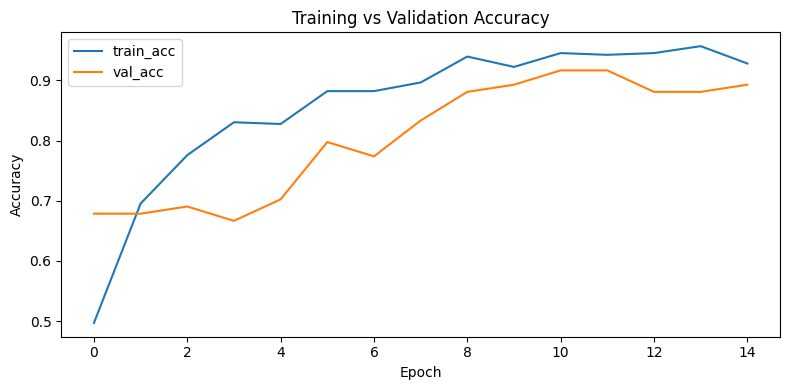

In [20]:
import matplotlib.pyplot as plt

print("Preview of per-sample probabilities:")
print(prob_df.head())

print("Label counts in processed audio:")
print(meta_df["label"].value_counts())

plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
from pathlib import Path

cache_dir = Path("../cache")
cache_dir.mkdir(parents=True, exist_ok=True)

if 'prob_df' not in globals():
    raise RuntimeError("Run the processing cell first to populate prob_df.")

audio_cache_path = cache_dir / "audio_probs.parquet"
prob_df.to_parquet(audio_cache_path, index=False)
print(f"Saved audio probabilities to {audio_cache_path} with {len(prob_df)} rows")


Saved audio probabilities to ../cache/audio_probs.parquet with 250 rows
